In [4]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

import skimage
from skimage.feature import peak_local_max
from skimage.io import imread
from skimage.io import imsave
import cv2
import tifffile

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
})


BASE_DIR = Path('E:\Chang')
RUN_ID = '20230704_PRISM3D_mousebrain_CTX_confocal'
src_dir = BASE_DIR / f'{RUN_ID}_processed'
stc_dir = src_dir / 'stitched'
read_dir = src_dir / 'readout'
tmp_dir = read_dir / 'tmp'
figure_dir = read_dir / 'figures'
os.makedirs(tmp_dir, exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)

In [5]:
def extract_coordinates(image, snr=4, quantile=0.96):
    meta = {}
    coordinates = peak_local_max(image,min_distance=2,threshold_abs=snr*np.mean(image))
    meta['Coordinates brighter than given SNR'] = coordinates.shape[0]
    meta['Image mean intensity'] = float(np.mean(image))
    intensities = image[coordinates[:,0],coordinates[:,1]]
    meta[f'{quantile} quantile'] = float(np.quantile(intensities,quantile))
    threshold = np.quantile(intensities,quantile)
    coordinates = coordinates[image[coordinates[:,0],coordinates[:,1]]>threshold]
    meta['Final spots count'] = coordinates.shape[0]
    return coordinates

# convert Maxima(x,y) to image
def find_signal(coordinates,im):
    Maxima = np.zeros(im.shape,dtype=np.uint16)
    Maxima[coordinates[:,0],coordinates[:,1]] = 255
    im[Maxima<=0] = 0 # Mask
    return im

TOPHAT_KERNEL_SIZE = 7
def tophat_spots(image):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(TOPHAT_KERNEL_SIZE,TOPHAT_KERNEL_SIZE))
    return cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)

def build_maxima (coordinates, shape):
    Maxima = np.zeros(shape, dtype=np.uint16)
    Maxima[coordinates['z_in_pix'],coordinates['x_in_pix'],coordinates['y_in_pix']] = coordinates['integratedIntensity']
    return Maxima

In [4]:
for i in range(1,5):
    locals()['z_Ch'+str(i)] = pd.read_csv(tmp_dir/f'Ch{i}_smoothed.loc4', sep='\t')[['x_in_pix','y_in_pix','z_in_pix','integratedIntensity']]
    eval(f'z_Ch{i}')['integratedIntensity'] = round(eval(f'z_Ch{i}')['integratedIntensity'])/200
    eval(f'z_Ch{i}')['x_in_pix'] = round(eval(f'z_Ch{i}')['x_in_pix'])-1
    eval(f'z_Ch{i}')['y_in_pix'] = round(eval(f'z_Ch{i}')['y_in_pix'])-1
    eval(f'z_Ch{i}')['z_in_pix'] = round(eval(f'z_Ch{i}')['z_in_pix'])-1
    locals()['z_Ch'+str(i)] = eval(f'z_Ch{i}').astype({'x_in_pix':int, 'y_in_pix':int, 'z_in_pix':int, 'integratedIntensity':int})

# readout of spots

In [4]:
# Dilation: 3 by 3
kernel = np.ones((5,5,5), dtype = np.uint16)
with tifffile.TiffFile(stc_dir/'Ch1_smoothed.tif') as tif:
    series = tif.series[0]
    im_shape = series.shape
test_1 = build_maxima (z_Ch1, im_shape)
test_1 = skimage.morphology.dilation(test_1, selem=kernel)
test_2 = build_maxima (z_Ch2, im_shape)
test_2 = skimage.morphology.dilation(test_2, selem=kernel)
test_3 = build_maxima (z_Ch3, im_shape)
test_3 = skimage.morphology.dilation(test_3, selem=kernel)
test_4 = build_maxima (z_Ch4, im_shape)
test_4 = skimage.morphology.dilation(test_4, selem=kernel)

# Save dilated image and coordinate
imsave(tmp_dir/'Ch1_z_combined-Dilation.tif', test_1, check_contrast=False)
z_Ch1.to_csv(tmp_dir/'Ch1_z_combined.csv')
imsave(tmp_dir/'Ch2_z_combined-Dilation.tif', test_2, check_contrast=False)
z_Ch2.to_csv(tmp_dir/'Ch2_z_combined.csv')
imsave(tmp_dir/'Ch3_z_combined-Dilation.tif', test_3, check_contrast=False)
z_Ch3.to_csv(tmp_dir/'Ch3_z_combined.csv')
imsave(tmp_dir/'Ch4_z_combined-Dilation.tif', test_4, check_contrast=False)
z_Ch4.to_csv(tmp_dir/'Ch4_z_combined.csv')

Opening readonly file: E:\Chang\20230704_ctx tile\0705_CTX_tile.ims 

Closing file: E:\Chang\20230704_ctx tile\0705_CTX_tile.ims 



C:\Users\PC\AppData\Local\Temp\ipykernel_20832\83384239.py:6: FutureWarning: `selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  test_1 = skimage.morphology.dilation(test_1, selem=kernel)
C:\Users\PC\AppData\Local\Temp\ipykernel_20832\83384239.py:8: FutureWarning: `selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  test_2 = skimage.morphology.dilation(test_2, selem=kernel)
C:\Users\PC\AppData\Local\Temp\ipykernel_20832\83384239.py:10: FutureWarning: `selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  test_3 = skimage.morphology.dilation(test_3, selem=kernel)
C:\Users\PC\AppData\Local\Temp\ipykernel_20832\83384239.py:12: FutureWarning: `selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  test_4 = skimage.morp

In [6]:
B_dilated = imread(tmp_dir/'Ch4_z_combined-Dilation.tif')
G_dilated = imread(tmp_dir/'Ch3_z_combined-Dilation.tif')
Y_dilated = imread(tmp_dir/'Ch2_z_combined-Dilation.tif')
R_dilated = imread(tmp_dir/'Ch1_z_combined-Dilation.tif')
B_coor = pd.read_csv(tmp_dir/'Ch4_z_combined.csv').drop(columns='Unnamed: 0')
G_coor = pd.read_csv(tmp_dir/'Ch3_z_combined.csv').drop(columns='Unnamed: 0')
Y_coor = pd.read_csv(tmp_dir/'Ch2_z_combined.csv').drop(columns='Unnamed: 0')
R_coor = pd.read_csv(tmp_dir/'Ch1_z_combined.csv').drop(columns='Unnamed: 0')
R_coor['R'] = R_dilated[R_coor['z_in_pix'],R_coor['x_in_pix'],R_coor['y_in_pix']]
R_coor['Y'] = Y_dilated[R_coor['z_in_pix'],R_coor['x_in_pix'],R_coor['y_in_pix']]
R_coor['B'] = B_dilated[R_coor['z_in_pix'],R_coor['x_in_pix'],R_coor['y_in_pix']]
R_coor['G'] = G_dilated[R_coor['z_in_pix'],R_coor['x_in_pix'],R_coor['y_in_pix']]
Y_coor['R'] = R_dilated[Y_coor['z_in_pix'],Y_coor['x_in_pix'],Y_coor['y_in_pix']]
Y_coor['Y'] = Y_dilated[Y_coor['z_in_pix'],Y_coor['x_in_pix'],Y_coor['y_in_pix']]
Y_coor['B'] = B_dilated[Y_coor['z_in_pix'],Y_coor['x_in_pix'],Y_coor['y_in_pix']]
Y_coor['G'] = G_dilated[Y_coor['z_in_pix'],Y_coor['x_in_pix'],Y_coor['y_in_pix']]
B_coor['R'] = R_dilated[B_coor['z_in_pix'],B_coor['x_in_pix'],B_coor['y_in_pix']]
B_coor['Y'] = Y_dilated[B_coor['z_in_pix'],B_coor['x_in_pix'],B_coor['y_in_pix']]
B_coor['B'] = B_dilated[B_coor['z_in_pix'],B_coor['x_in_pix'],B_coor['y_in_pix']]
B_coor['G'] = G_dilated[B_coor['z_in_pix'],B_coor['x_in_pix'],B_coor['y_in_pix']]
intensity_all = pd.concat([R_coor,Y_coor,B_coor])#,keys=['R','Ye','B','G'])
intensity_all = intensity_all.drop(columns='integratedIntensity') #integratedIntensity
intensity_all.to_csv(read_dir/'intensity_all.csv')
intensity_all

,x_in_pix,y_in_pix,z_in_pix,R,Y,B,G
0,126,46,18,12269,2863,0,0
1,580,663,16,12169,2534,3198,10718
2,198,531,26,11635,2468,0,0
3,616,2341,20,11628,1817,0,0
4,1384,1772,16,11619,1937,0,0
...,...,...,...,...,...,...,...
137651,67,4368,73,97,0,87,0
137652,1293,438,60,0,0,67,0
137653,1317,4450,44,0,0,65,0
137654,1645,1929,21,0,0,64,0


In [6]:
# Scale colors to similar range
channel = {'R','Y','G','B'}
for color in channel:
    a_scale = intensity_all[color]
    a_scale = a_scale[a_scale>0]
    print(color,':', np.median(np.unique(a_scale)))

Y : 4129.0
B : 4925.0
G : 5031.0
R : 4575.5


In [7]:
intensity_all['Scaled_R'] = intensity_all['R'] 
intensity_all['Scaled_Ye'] = intensity_all['Y'] 
intensity_all['Scaled_G'] = intensity_all['G'] 
intensity_all['Scaled_B'] = intensity_all['B'] 
intensity_all['sum'] = intensity_all['Scaled_R'] + intensity_all['Scaled_Ye'] + intensity_all['Scaled_B']
#filter by sum value (QC)
intensity_all = intensity_all.drop(intensity_all[intensity_all['sum'] < 100].index) #1500
intensity_all = intensity_all.drop(intensity_all[intensity_all['sum'] > 50000].index)
intensity_all['R/A'] = intensity_all['Scaled_R'] / intensity_all['sum']
intensity_all['Ye/A'] = intensity_all['Scaled_Ye'] / intensity_all['sum']
intensity_all['B/A'] = intensity_all['Scaled_B'] / intensity_all['sum']
intensity_all['G/A'] = intensity_all['Scaled_G'] / intensity_all['sum']
intensity_all['X_coor'] = 2*intensity_all['R/A'] - 1
intensity_all['Y_coor'] = intensity_all['B/A'] - intensity_all['Ye/A']
intensity_all

,x_in_pix,y_in_pix,z_in_pix,R,Y,B,G,Scaled_R,Scaled_Ye,Scaled_G,Scaled_B,sum,R/A,Ye/A,B/A,G/A,X_coor,Y_coor
0,126,46,18,12269,2863,0,0,12269,2863,0,0,15132,0.810798,0.189202,0.000000,0.000000,0.621597,-0.189202
1,580,663,16,12169,2534,3198,10718,12169,2534,10718,3198,17901,0.679794,0.141556,0.178649,0.598738,0.359589,0.037093
2,198,531,26,11635,2468,0,0,11635,2468,0,0,14103,0.825002,0.174998,0.000000,0.000000,0.650004,-0.174998
3,616,2341,20,11628,1817,0,0,11628,1817,0,0,13445,0.864857,0.135143,0.000000,0.000000,0.729714,-0.135143
4,1384,1772,16,11619,1937,0,0,11619,1937,0,0,13556,0.857111,0.142889,0.000000,0.000000,0.714222,-0.142889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137642,457,4678,49,0,0,117,0,0,0,0,117,117,0.000000,0.000000,1.000000,0.000000,-1.000000,1.000000
137643,846,1202,14,0,0,114,0,0,0,0,114,114,0.000000,0.000000,1.000000,0.000000,-1.000000,1.000000
137644,721,198,75,0,0,105,0,0,0,0,105,105,0.000000,0.000000,1.000000,0.000000,-1.000000,1.000000
137645,430,5232,85,0,0,101,0,0,0,0,101,101,0.000000,0.000000,1.000000,0.000000,-1.000000,1.000000


# Gene calling

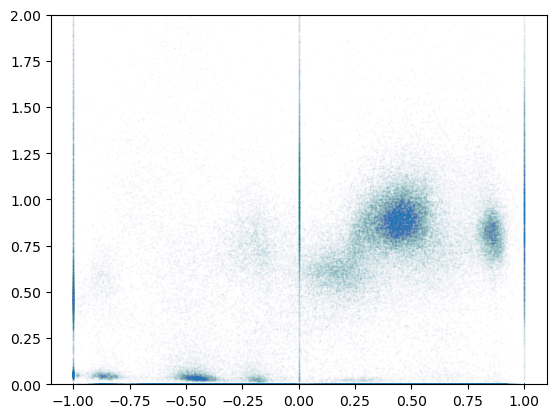

In [8]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.scatter(intensity_all['Y_coor'],intensity_all['G/A'],s=0.3,alpha=0.01,linewidths=None)
plt.ylim([0,2])
plt.xlim([-1.1,1.1])
plt.savefig(figure_dir/'0G_1G.jpg')

In [9]:
intensity_low = intensity_all[intensity_all['G/A']<=0.125]
intensity_high = intensity_all[intensity_all['G/A']>=0.25]

Peaks range of RY [(-1.0, -0.99), (-0.98, -0.86), (-0.85, -0.73), (-0.72, -0.6699999999999999), (-0.6599999999999999, -0.52), (-0.51, -0.45999999999999996), (-0.44999999999999996, -0.33999999999999997), (-0.32999999999999996, -0.17999999999999994), (-0.16999999999999993, -0.08999999999999997), (-0.07999999999999996, -0.030000000000000027), (-0.020000000000000018, 0.8800000000000001), (0.8900000000000001, 0.98), (0.99, 1.0)] 

Peaks range of RB [(-1.0, -0.99), (-0.98, -0.44999999999999996), (-0.43999999999999995, -0.33999999999999997), (-0.32999999999999996, -0.08999999999999997), (-0.07999999999999996, 0.010000000000000009), (0.020000000000000018, 0.09000000000000008), (0.99, 1.0)] 

Peaks range of BY [(-1.0, -0.99), (-0.85, -0.53), (-0.52, -0.45999999999999996), (-0.44999999999999996, -0.37), (-0.36, -0.22999999999999998), (-0.21999999999999997, -0.13), (-0.12, 0.41999999999999993), (0.42999999999999994, 0.5900000000000001), (0.6000000000000001, 0.9000000000000001), (0.910000000000000

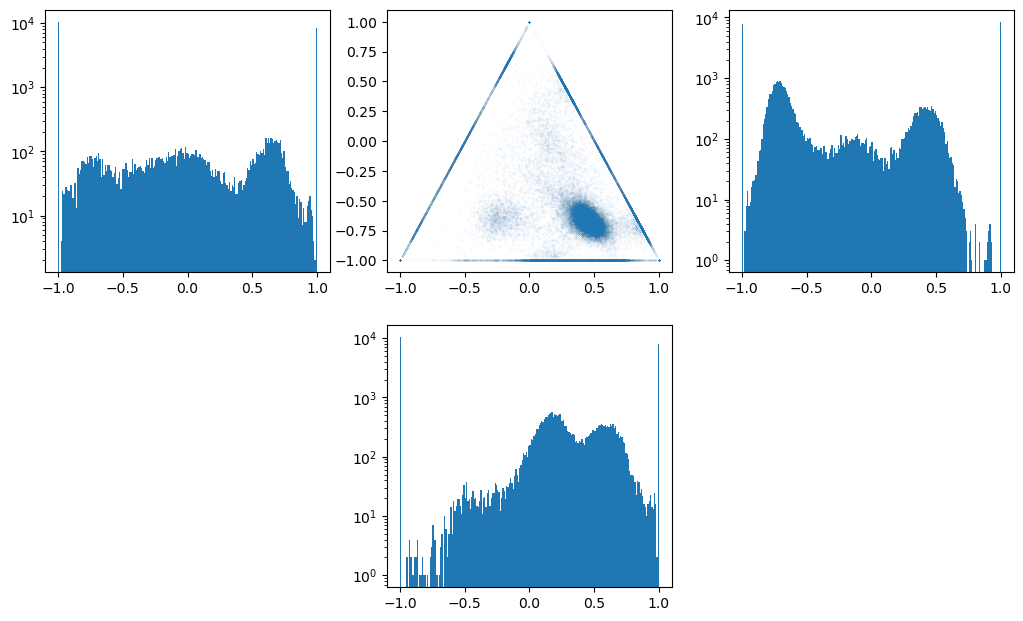

In [10]:
from xml.dom.expatbuilder import InternalSubsetExtractor
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
})
import matplotlib.pyplot as plt
plt.style.use('default')

def plot_freq(intensity, colorline, layer='1G', layer_threshold=0.25, order=5, contraction=0, vlines=True, curvefit_range=None, curvefit_p0=None,curvefit_pvalue=0.1, curvefit_colorset=['red', 'yellow', 'green'], save=False, read_dir=None):
    '''
    Plot a frequency plot.

    Parameters
    -----------
    intensity: pandas dataframe.
    colorline: projection line. 'RY', 'RB' or 'BY'.
    layer: the 4th color. '0G' or '1G'.
    layer_threshold: threshold of the 4th color. For '0G', it is the upper limit. For '1G', it is the lower limit.
    order: how many points on each side to use for the comparison to consider. For details, see scipy.signal.argrelextrema.
    contraction: distance between two peaks (= contraction*2). 
    vlines: whether to plot peak boundaries or not.
    curvefit_range: peak range to fit curve.
    curvefit_p0: initial guess for the parameters (length N). For details, see scipy.optimize.curve_fit.
    save: whether to save the plot alone.
    read_dir: 
    '''
    
    def gaussian(x, mu, sigma, A):
        return A*np.exp(-(x-mu)**2/(2*(sigma**2)))

    def mixgaussian(x, mu1, mu2, mu3, sigma1, sigma2, sigma3, A1, A2, A3):
        return gaussian(x, mu1, sigma1, A1) + gaussian(x, mu2, sigma2, A2) + gaussian(x, mu3, sigma3, A3)

    if layer == '0G':
        intensity = intensity[intensity['G/A'] <= layer_threshold]
    elif layer == '1G':
        intensity = intensity[intensity['G/A'] >= layer_threshold]

    if colorline == 'RY':
        intensity = intensity[intensity['B/A'] == 0] 
        intensity = intensity['R/A'] - intensity['Ye/A']
    elif colorline == 'RB':
        intensity = intensity[intensity['Ye/A'] == 0]
        intensity = intensity['R/A'] - intensity['B/A']
    elif colorline == 'BY':
        intensity = intensity[intensity['R/A'] == 0]
        intensity = intensity['B/A'] - intensity['Ye/A']
    
   
    hist=plt.hist(pd.DataFrame(intensity), bins = 200,log=True)


    freq, bins = hist[0], hist[1]
    extrema_less = argrelextrema(freq, np.less, order=order)[0] # assuming two side have 0, execute this code, or skip it
    # extrema_less = np.insert(extrema_less, 0, 3)
    # extrema_less = np.append(extrema_less, -3)
    bins_less = [(bins[extrema_less[i-1]+1]+contraction, bins[extrema_less[i]]-contraction) if i>0 else (bins[0], bins[1]) for i in range(len(extrema_less))]
    bins_less.append((bins[-2], bins[-1]))
    print('Peaks range of', colorline, bins_less, '\n')

    if vlines:
        plt.vlines([i[0] for i in bins_less], 0, 10000, linestyles='dashed', colors='red')
        plt.vlines([i[1] for i in bins_less], 0, 10000, linestyles='dashed', colors='green')

    if curvefit_range:
        confidence = 1 - curvefit_pvalue
        if confidence == 0.9:
            z = 1.28
        elif confidence == 0.95:
            z = 1.64
        start_idx, end_idx = curvefit_range[0], curvefit_range[1]
        bins_ = (bins[1:] + bins[:-1])/2 # for len(bins_) == len(freq)
        popt, pcov = curve_fit(mixgaussian, bins_[start_idx:end_idx], freq[start_idx:end_idx], p0=curvefit_p0, maxfev=1000000)
        # print('Fitting parameters: mu1, mu2, mu3, sigma1, sigma2, sigma3, A1, A2, A3\n', popt, '\n')
        # plt.plot(bins_[start_idx:end_idx], mixgaussian(bins_[start_idx:end_idx], *popt))

        # plot fitting curve separately: curve 1, curve 2, curve 3
        # curve 1
        mu, sigma, A = popt[0], popt[3], popt[6]
        plt.plot(bins_, gaussian(bins_, mu=mu, sigma=sigma, A=A), color=curvefit_colorset[0])
        print('Gaussian Curve 1: {A:.2f}*np.exp(-(x-{mu:.2f})**2/(2*({sigma:.2f}**2)))'.format(mu=mu, sigma=sigma, A=A))
        print(confidence*100, '% confidence interval:', [mu-z*sigma, mu+z*sigma])
        # curve 2
        mu, sigma, A = popt[1], popt[4], popt[7]
        plt.plot(bins_, gaussian(bins_, mu=mu, sigma=sigma, A=A), color=curvefit_colorset[1])
        print('Gaussian Curve 2: {A:.2f}*np.exp(-(x-{mu:.2f})**2/(2*({sigma:.2f}**2)))'.format(mu=mu, sigma=sigma, A=A))
        print(confidence*100, '% confidence interval:', [mu-z*sigma, mu+z*sigma])
        # curve 3
        mu, sigma, A = popt[2], popt[5], popt[8]
        plt.plot(bins_, gaussian(bins_, mu=mu, sigma=sigma, A=A), color=curvefit_colorset[2])
        print('Gaussian Curve 3: {A:.2f}*np.exp(-(x-{mu:.2f})**2/(2*({sigma:.2f}**2)))'.format(mu=mu, sigma=sigma, A=A))
        print(confidence*100, '% confidence interval:', [mu-z*sigma, mu+z*sigma])

    if save: plt.savefig(figure_dir/(colorline+'_'+layer+'.jpg'))
    else: plt.show()
    
# plots: scatter + frequency plot in three dimension
fig = plt.figure()    # 生成新的画布fig
fig.set_size_inches(12.5, 7.5)     # 调整画布为合适大小

p0 = [-1, 1, 1, 1, 3, 3]
plt.subplot(232)  # scatter
plt.scatter(intensity_high['Y_coor'], intensity_high['X_coor'], s=0.009, alpha=0.08, linewidths=None)
plt.subplot(231)   # red-yellow
plot_freq(intensity_all, colorline='RY', layer='1G', layer_threshold=0.2, vlines=False)#, curvefit_range=(10,190), curvefit_p0=(-0.5, 0, 0.5, 0.1, 0.1, 0.1, 1500, 1500, 22000),curvefit_colorset=['gold', 'darkorange', 'orangered'])#, save=True, read_dir=src_dir / 'readout')
#plt.ylim([0,1000])
#plt.xlim([-1.2,1.2])
plt.subplot(233)   # red-blue
plot_freq(intensity_all, colorline='RB', layer='1G', layer_threshold=0.2, vlines=False)#, curvefit_range=(10,190), curvefit_p0=(-0.7, -0.25, 0.35, 0.1, 0.1, 0.1, 5000, 5000, 5000),curvefit_colorset=['darkviolet', 'magenta', 'deeppink'])#, save=True, read_dir=src_dir / 'readout')
#plt.ylim([0,1000])
#plt.xlim([-1.2,1.2])
plt.subplot(235)   # yellow-blue
plot_freq(intensity_all, colorline='BY', layer='1G', layer_threshold=0.2, vlines=False)#, save=True, read_dir=src_dir / 'readout')#, curvefit_range=(20,190), curvefit_p0=(-0.4, 0.2, 0.6, 0.1, 0.1, 0.1, 3000, 10000, 20000),curvefit_colorset=['greenyellow', 'springgreen', 'deepskyblue'], save=True, read_dir=src_dir / 'readout')
#plt.ylim([0,1000])
#plt.xlim([-1.2,1.2])
plt.show()


Peaks range of RY [(-1.0, -0.9933333333333333), (-0.9866666666666667, -0.9133333333333333), (-0.9066666666666666, -0.5333333333333333), (-0.5266666666666666, -0.4666666666666667), (-0.45999999999999996, 0.3733333333333335), (0.3800000000000001, 0.8866666666666667), (0.8933333333333335, 0.9866666666666668), (0.9933333333333334, 1.0)] 

Peaks range of RB [(-1.0, -0.9933333333333333), (-0.5266666666666666, -0.4733333333333333), (-0.4666666666666667, -0.31999999999999995), (-0.31333333333333324, -0.17999999999999994), (-0.17333333333333323, 0.040000000000000036), (0.046666666666666634, 0.16000000000000014), (0.16666666666666674, 0.3866666666666667), (0.3933333333333333, 0.6066666666666667), (0.6133333333333335, 0.6600000000000001), (0.6666666666666667, 0.7066666666666668), (0.7133333333333334, 0.7866666666666668), (0.7933333333333334, 0.8400000000000001), (0.9933333333333334, 1.0)] 

Peaks range of BY [(-1.0, -0.9933333333333333), (-0.8866666666666667, -0.8533333333333333), (-0.84666666666

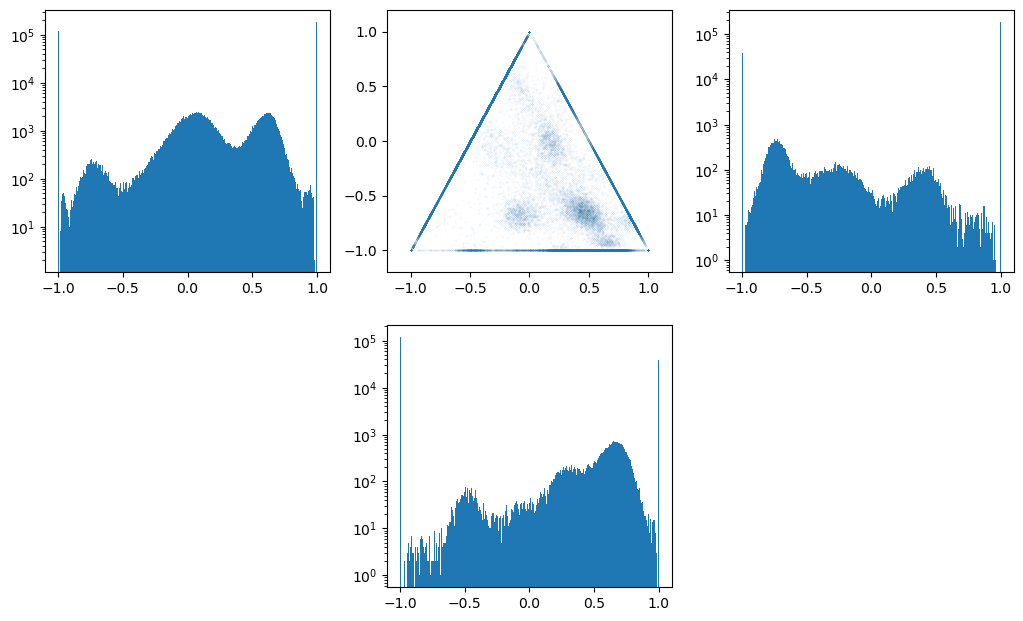

In [ ]:
from xml.dom.expatbuilder import InternalSubsetExtractor
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
})

import matplotlib.pyplot as plt
plt.style.use('default')
def plot_freq(intensity, colorline, layer='1G', layer_threshold=0.25, order=5, contraction=0, vlines=True, curvefit_range=None, curvefit_p0=None,curvefit_pvalue=0.1, curvefit_colorset=['red', 'yellow', 'green'], save=False, read_dir=None):
    '''
    Plot a frequency plot.

    Parameters
    -----------
    intensity: pandas dataframe.
    colorline: projection line. 'RY', 'RB' or 'BY'.
    layer: the 4th color. '0G' or '1G'.
    layer_threshold: threshold of the 4th color. For '0G', it is the upper limit. For '1G', it is the lower limit.
    order: how many points on each side to use for the comparison to consider. For details, see scipy.signal.argrelextrema.
    contraction: distance between two peaks (= contraction*2). 
    vlines: whether to plot peak boundaries or not.
    curvefit_range: peak range to fit curve.
    curvefit_p0: initial guess for the parameters (length N). For details, see scipy.optimize.curve_fit.
    save: whether to save the plot alone.
    read_dir: 
    '''
    
    def gaussian(x, mu, sigma, A):
        return A*np.exp(-(x-mu)**2/(2*(sigma**2)))

    def mixgaussian(x, mu1, mu2, mu3, sigma1, sigma2, sigma3, A1, A2, A3):
        return gaussian(x, mu1, sigma1, A1) + gaussian(x, mu2, sigma2, A2) + gaussian(x, mu3, sigma3, A3)

    if layer == '0G':
        intensity = intensity[intensity['G/A'] <= layer_threshold]
    elif layer == '1G':
        intensity = intensity[intensity['G/A'] >= layer_threshold]

    if colorline == 'RY':
        intensity = intensity[intensity['B/A'] == 0] 
        intensity = intensity['R/A'] - intensity['Ye/A']
    elif colorline == 'RB':
        intensity = intensity[intensity['Ye/A'] == 0]
        intensity = intensity['R/A'] - intensity['B/A']
    elif colorline == 'BY':
        intensity = intensity[intensity['R/A'] == 0]
        intensity = intensity['B/A'] - intensity['Ye/A']

    hist = plt.hist(pd.DataFrame(intensity), bins = 300,log=True)
    freq, bins = hist[0], hist[1]
    extrema_less = argrelextrema(freq, np.less, order=order)[0] # assuming two side have 0, execute this code, or skip it
    # extrema_less = np.insert(extrema_less, 0, 3)
    # extrema_less = np.append(extrema_less, -3)
    bins_less = [(bins[extrema_less[i-1]+1]+contraction, bins[extrema_less[i]]-contraction) if i>0 else (bins[0], bins[1]) for i in range(len(extrema_less))]
    bins_less.append((bins[-2], bins[-1]))
    print('Peaks range of', colorline, bins_less, '\n')

    if vlines:
        plt.vlines([i[0] for i in bins_less], 0, 10000, linestyles='dashed', colors='red')
        plt.vlines([i[1] for i in bins_less], 0, 10000, linestyles='dashed', colors='green')

    if curvefit_range:
        confidence = 1 - curvefit_pvalue
        if confidence == 0.9:
            z = 1.28
        elif confidence == 0.95:
            z = 1.64
        start_idx, end_idx = curvefit_range[0], curvefit_range[1]
        bins_ = (bins[1:] + bins[:-1])/2 # for len(bins_) == len(freq)
        popt, pcov = curve_fit(mixgaussian, bins_[start_idx:end_idx], freq[start_idx:end_idx], p0=curvefit_p0, maxfev=1000000)
        # print('Fitting parameters: mu1, mu2, mu3, sigma1, sigma2, sigma3, A1, A2, A3\n', popt, '\n')
        # plt.plot(bins_[start_idx:end_idx], mixgaussian(bins_[start_idx:end_idx], *popt))

        # plot fitting curve separately: curve 1, curve 2, curve 3
        # curve 1
        mu, sigma, A = popt[0], popt[3], popt[6]
        plt.plot(bins_, gaussian(bins_, mu=mu, sigma=sigma, A=A), color=curvefit_colorset[0])
        print('Gaussian Curve 1: {A:.2f}*np.exp(-(x-{mu:.2f})**2/(2*({sigma:.2f}**2)))'.format(mu=mu, sigma=sigma, A=A))
        print(confidence*100, '% confidence interval:', [mu-z*sigma, mu+z*sigma])
        # curve 2
        mu, sigma, A = popt[1], popt[4], popt[7]
        plt.plot(bins_, gaussian(bins_, mu=mu, sigma=sigma, A=A), color=curvefit_colorset[1])
        print('Gaussian Curve 2: {A:.2f}*np.exp(-(x-{mu:.2f})**2/(2*({sigma:.2f}**2)))'.format(mu=mu, sigma=sigma, A=A))
        print(confidence*100, '% confidence interval:', [mu-z*sigma, mu+z*sigma])
        # curve 3
        mu, sigma, A = popt[2], popt[5], popt[8]
        plt.plot(bins_, gaussian(bins_, mu=mu, sigma=sigma, A=A), color=curvefit_colorset[2])
        print('Gaussian Curve 3: {A:.2f}*np.exp(-(x-{mu:.2f})**2/(2*({sigma:.2f}**2)))'.format(mu=mu, sigma=sigma, A=A))
        print(confidence*100, '% confidence interval:', [mu-z*sigma, mu+z*sigma])

    if save: plt.savefig(figure_dir/(colorline+'_'+layer+'.jpg'))
    else: plt.show()

# plots: scatter + frequency plot in three dimension
fig = plt.figure()    # 生成新的画布fig
fig.set_size_inches(12.5, 7.5)     # 调整画布为合适大小

p0 = [-1, 1, 1, 1, 3, 3]
plt.subplot(232)  # scatter
plt.scatter(intensity_low['Y_coor'], intensity_low['X_coor'], s=0.009, alpha=0.08, linewidths=None)
plt.ylim([-1.2,1.2])
plt.xlim([-1.2,1.2])
plt.subplot(231)   # red-yellow
plot_freq(intensity_all, colorline='RY', layer='0G', layer_threshold=0.12, vlines=False)#, curvefit_range=(10,190), curvefit_p0=(-0.5, 0, 0.5, 0.1, 0.1, 0.1, 1500, 1500, 22000),curvefit_colorset=['gold', 'darkorange', 'orangered'])#, save=True, read_dir=src_dir / 'readout')
plt.subplot(233)   # red-blue
plot_freq(intensity_all, colorline='RB', layer='0G', layer_threshold=0.12, vlines=False)#, curvefit_range=(10,190), curvefit_p0=(-0.7, -0.25, 0.35, 0.1, 0.1, 0.1, 5000, 5000, 5000),curvefit_colorset=['darkviolet', 'magenta', 'deeppink'])#, save=True, read_dir=src_dir / 'readout')
plt.subplot(235)   # yellow-blue
plot_freq(intensity_all, colorline='BY', layer='0G', layer_threshold=0.12, vlines=False)#, save=True, read_dir=src_dir / 'readout')#, curvefit_range=(20,190), curvefit_p0=(-0.4, 0.2, 0.6, 0.1, 0.1, 0.1, 3000, 10000, 20000),curvefit_colorset=['greenyellow', 'springgreen', 'deepskyblue'], save=True, read_dir=src_dir / 'readout')
plt.show()

In [8]:
#E14.5 New version

G_Low_Thre = 0.1
G_High_Thre = 0.25

PRISM_1_XL = 0.91

PRISM_2_XL = 0.4
PRISM_2_XH = 0.87

PRISM_3_XL = -0.4
PRISM_3_XH = 0.39

PRISM_4_XL = -0.85
PRISM_4_XH = -0.41

PRISM_5_XH = -0.95

PRISM_6_XL = -0.65
PRISM_6_XH = -0.25

PRISM_7_XL = 0.15
PRISM_7_XH = 0.42

PRISM_8_XL = 0.5
PRISM_8_XH = 0.9

PRISM_9_XL = 0.99

PRISM_10_XL = -0.95
PRISM_10_XH = -0.5

PRISM_11_XL = -0.5
PRISM_11_XH = 0

PRISM_12_XL = 0.1
PRISM_12_XH = 0.675 #

PRISM_13_XL = -0.2
PRISM_13_XH = 0.2
PRISM_13_YL = 0.05
PRISM_13_YH = 0.35

PRISM_14_XL = -0.8
PRISM_14_XH = -0.5
PRISM_14_YL = -0.3
PRISM_14_YH = 0.1

PRISM_15_XL = -0.8
PRISM_15_XH = -0.5
PRISM_15_YL = 0.25
PRISM_15_YH = 0.6

PRISM_16_XL = 0.9 # 0.78

PRISM_17_XL = 0.4
PRISM_17_XH = 0.95

PRISM_18_XL = -0.25
PRISM_18_XH = 0.35 #

PRISM_19_XL = -0.84
PRISM_19_XH = -0.5

PRISM_20_XH = -0.88 #contract!

PRISM_21_XL = -0.75
PRISM_21_XH = -0.2

PRISM_22_XL = -0.15
PRISM_22_XH = 0.34

PRISM_23_XL = 0.37
PRISM_23_XH = 0.89

PRISM_24_XL = 0.99

PRISM_25_XL = -0.9 #
PRISM_25_XH = -0.46

PRISM_26_XL = -0.43
PRISM_26_XH = 0.1

PRISM_27_XL = 0.12
PRISM_27_XH = 0.75 #

PRISM_28_XL = -0.25
PRISM_28_XH = 0.25
PRISM_28_YL = 0
PRISM_28_YH = 0.25

PRISM_29_XL = -0.8
PRISM_29_XH = -0.5
PRISM_29_YL = -0.4
PRISM_29_YH = -0.05

PRISM_30_XL = -0.8
PRISM_30_XH = -0.45
PRISM_30_YL = 0.3
PRISM_30_YH = 0.6

PRISM_2_XL_Range = 0.9*PRISM_2_XL+0.1*PRISM_2_XH
PRISM_2_XH_Range = 0.1*PRISM_2_XL+0.9*PRISM_2_XH
PRISM_3_XL_Range = 0.9*PRISM_3_XL+0.1*PRISM_3_XH
PRISM_3_XH_Range = 0.1*PRISM_3_XL+0.9*PRISM_3_XH
PRISM_4_XL_Range = 0.9*PRISM_4_XL+0.1*PRISM_4_XH
PRISM_4_XH_Range = 0.1*PRISM_4_XL+0.9*PRISM_4_XH
PRISM_6_XL_Range = 0.9*PRISM_6_XL+0.1*PRISM_6_XH
PRISM_6_XH_Range = 0.1*PRISM_6_XL+0.9*PRISM_6_XH
PRISM_7_XL_Range = 0.9*PRISM_7_XL+0.1*PRISM_7_XH
PRISM_7_XH_Range = 0.1*PRISM_7_XL+0.9*PRISM_7_XH
PRISM_8_XL_Range = 0.9*PRISM_8_XL+0.1*PRISM_8_XH
PRISM_8_XH_Range = 0.1*PRISM_8_XL+0.9*PRISM_8_XH
PRISM_10_XL_Range = 0.9*PRISM_10_XL+0.1*PRISM_10_XH
PRISM_10_XH_Range = 0.1*PRISM_10_XL+0.9*PRISM_10_XH
PRISM_11_XL_Range = 0.9*PRISM_11_XL+0.1*PRISM_11_XH
PRISM_11_XH_Range = 0.1*PRISM_11_XL+0.9*PRISM_11_XH
PRISM_12_XL_Range = 0.9*PRISM_12_XL+0.1*PRISM_12_XH
PRISM_12_XH_Range = 0.1*PRISM_12_XL+0.9*PRISM_12_XH

PRISM_17_XL_Range = 0.9*PRISM_17_XL+0.1*PRISM_17_XH
PRISM_17_XH_Range = 0.1*PRISM_17_XL+0.9*PRISM_17_XH
PRISM_18_XL_Range = 0.9*PRISM_18_XL+0.1*PRISM_18_XH
PRISM_18_XH_Range = 0.1*PRISM_18_XL+0.9*PRISM_18_XH
PRISM_19_XL_Range = 0.9*PRISM_19_XL+0.1*PRISM_19_XH
PRISM_19_XH_Range = 0.1*PRISM_19_XL+0.9*PRISM_19_XH
PRISM_21_XL_Range = 0.9*PRISM_21_XL+0.1*PRISM_21_XH
PRISM_21_XH_Range = 0.1*PRISM_21_XL+0.9*PRISM_21_XH
PRISM_22_XL_Range = 0.9*PRISM_22_XL+0.1*PRISM_22_XH
PRISM_22_XH_Range = 0.1*PRISM_22_XL+0.9*PRISM_22_XH
PRISM_23_XL_Range = 0.9*PRISM_23_XL+0.1*PRISM_23_XH
PRISM_23_XH_Range = 0.1*PRISM_23_XL+0.9*PRISM_23_XH
PRISM_25_XL_Range = 0.9*PRISM_25_XL+0.1*PRISM_25_XH
PRISM_25_XH_Range = 0.1*PRISM_25_XL+0.9*PRISM_25_XH
PRISM_26_XL_Range = 0.9*PRISM_26_XL+0.1*PRISM_26_XH
PRISM_26_XH_Range = 0.1*PRISM_26_XL+0.9*PRISM_26_XH
PRISM_27_XL_Range = 0.9*PRISM_27_XL+0.1*PRISM_27_XH
PRISM_27_XH_Range = 0.1*PRISM_27_XL+0.9*PRISM_27_XH

intensity_all['Gene'] = 'Other'
intensity_all.loc[(intensity_all.X_coor >= PRISM_1_XL)&(intensity_all['G/A'] <= G_Low_Thre)&(intensity_all['R']>= 2500),'Gene'] = 'PRISM_1'
intensity_all.loc[(intensity_all.X_coor >= PRISM_2_XL_Range)&(intensity_all.X_coor <= PRISM_2_XH_Range)&(intensity_all.Y_coor >= (PRISM_2_XL_Range-1)/2)&(intensity_all.Y_coor <= (PRISM_2_XH_Range-1)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_2'
intensity_all.loc[(intensity_all.X_coor >= PRISM_3_XL_Range)&(intensity_all.X_coor <= PRISM_3_XH_Range)&(intensity_all.Y_coor >= (PRISM_3_XL_Range-1)/2)&(intensity_all.Y_coor <= (PRISM_3_XH_Range-1)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_3'
intensity_all.loc[(intensity_all.X_coor >= PRISM_4_XL_Range)&(intensity_all.X_coor <= PRISM_4_XH_Range)&(intensity_all.Y_coor >= (PRISM_4_XL_Range-1)/2)&(intensity_all.Y_coor <= (PRISM_4_XH_Range-1)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_4'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= PRISM_5_XH)&(intensity_all['G/A'] <= G_Low_Thre)&(intensity_all['Y']>= 4000),'Gene'] = 'PRISM_5'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_6_XL_Range)&(intensity_all.Y_coor <= PRISM_6_XH_Range)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_6'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_7_XL_Range)&(intensity_all.Y_coor <= PRISM_7_XH_Range)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_7'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_8_XL_Range)&(intensity_all.Y_coor <= PRISM_8_XH_Range)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_8'
intensity_all.loc[(intensity_all.X_coor <= -0.999)&(intensity_all.Y_coor >= PRISM_9_XL)&(intensity_all['G/A'] <= G_Low_Thre)&(intensity_all['B']>= 4000),'Gene'] = 'PRISM_9'
intensity_all.loc[(intensity_all.X_coor >= PRISM_10_XL_Range)&(intensity_all.X_coor <= PRISM_10_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_10_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_10_XL_Range)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_10'
intensity_all.loc[(intensity_all.X_coor >= PRISM_11_XL_Range)&(intensity_all.X_coor <= PRISM_11_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_11_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_11_XL_Range)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_11'
intensity_all.loc[(intensity_all.X_coor >= PRISM_12_XL_Range)&(intensity_all.X_coor <= PRISM_12_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_12_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_12_XL_Range)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_12'
intensity_all.loc[(intensity_all.X_coor >= PRISM_13_XL)&(intensity_all.X_coor <= PRISM_13_XH)&(intensity_all.Y_coor >= PRISM_13_YL)&(intensity_all.Y_coor <= PRISM_13_YH)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_13'
intensity_all.loc[(intensity_all.X_coor >= PRISM_14_XL)&(intensity_all.X_coor <= PRISM_14_XH)&(intensity_all.Y_coor >= PRISM_14_YL)&(intensity_all.Y_coor <= PRISM_14_YH)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_14'
intensity_all.loc[(intensity_all.X_coor >= PRISM_15_XL)&(intensity_all.X_coor <= PRISM_15_XH)&(intensity_all.Y_coor >= PRISM_15_YL)&(intensity_all.Y_coor <= PRISM_15_YH)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_15'

intensity_all.loc[(intensity_all.X_coor >= PRISM_16_XL)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= G_High_Thre)&(intensity_all['R']>= 1000),'Gene'] = 'PRISM_16'
intensity_all.loc[(intensity_all.X_coor >= PRISM_17_XL_Range)&(intensity_all.X_coor <= PRISM_17_XH)&(intensity_all.Y_coor >= (PRISM_17_XL_Range-1)/2)&(intensity_all.Y_coor <= (PRISM_17_XH_Range-1)/2)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_17'
intensity_all.loc[(intensity_all.X_coor >= PRISM_18_XL_Range)&(intensity_all.X_coor <= PRISM_18_XH_Range)&(intensity_all.Y_coor >= (PRISM_18_XL_Range-1)/2)&(intensity_all.Y_coor <= -0.35)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_18'
intensity_all.loc[(intensity_all.X_coor >= PRISM_19_XL_Range)&(intensity_all.X_coor <= PRISM_19_XH_Range)&(intensity_all.Y_coor >=  (PRISM_19_XL_Range-1)/2)&(intensity_all.Y_coor <= -0.55)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_19'

intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= PRISM_20_XH)&(intensity_all['G/A'] >= G_High_Thre)&(intensity_all['Y']>= 1000),'Gene'] = 'PRISM_20'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_21_XL_Range)&(intensity_all.Y_coor <= PRISM_21_XH_Range)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_21'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_22_XL_Range)&(intensity_all.Y_coor <= PRISM_22_XH_Range)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_22'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_23_XL_Range)&(intensity_all.Y_coor <= PRISM_23_XH_Range)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_23'
intensity_all.loc[(intensity_all.X_coor <= -0.999)&(intensity_all.Y_coor >= PRISM_24_XL)&(intensity_all['G/A'] >= G_High_Thre)&(intensity_all['B']>= 2500),'Gene'] = 'PRISM_24'
intensity_all.loc[(intensity_all.X_coor >= PRISM_25_XL_Range)&(intensity_all.X_coor <= PRISM_25_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_25_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_25_XL_Range)/2)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_25'
intensity_all.loc[(intensity_all.X_coor >= PRISM_26_XL_Range)&(intensity_all.X_coor <= PRISM_26_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_26_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_26_XL_Range)/2)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_26'
intensity_all.loc[(intensity_all.X_coor >= PRISM_27_XL_Range)&(intensity_all.X_coor <= PRISM_27_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_27_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_27_XL_Range)/2)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_27'
intensity_all.loc[(intensity_all.X_coor >= PRISM_28_XL)&(intensity_all.X_coor <= PRISM_28_XH)&(intensity_all.Y_coor >= PRISM_28_YL)&(intensity_all.Y_coor <= PRISM_28_YH)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_28'
intensity_all.loc[(intensity_all.X_coor >= PRISM_29_XL)&(intensity_all.X_coor <= PRISM_29_XH)&(intensity_all.Y_coor >= PRISM_29_YL)&(intensity_all.Y_coor <= PRISM_29_YH)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_29'
intensity_all.loc[(intensity_all.X_coor >= PRISM_30_XL)&(intensity_all.X_coor <= PRISM_30_XH)&(intensity_all.Y_coor >= PRISM_30_YL)&(intensity_all.Y_coor <= PRISM_30_YH)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_30'
#intensity_all.loc[(intensity_all['G/A'] >= 10)&(intensity_all['G']>= 4000),'Gene'] = 'PRISM_31'

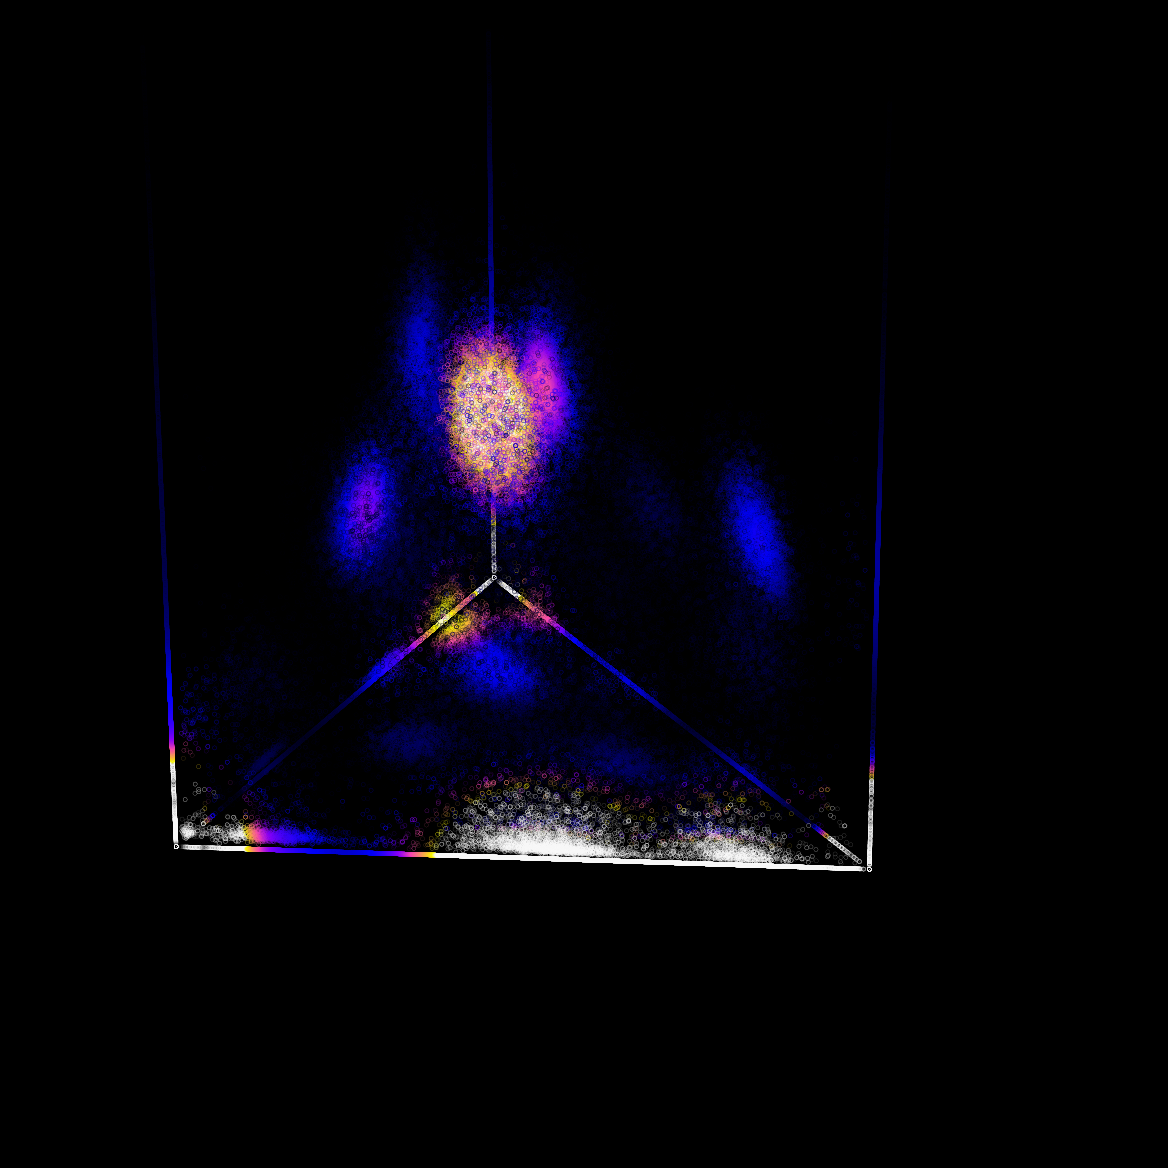

In [10]:
pretreat = intensity_all.sample(frac=1,replace=True, random_state=1)
sample = pretreat[['X_coor','Y_coor','G/A']]
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

mu, sigma = 0, 0.1 
x = np.array(sample['X_coor'])
y = np.array(sample['Y_coor'])
z = np.array(sample['G/A'])

xyz = np.vstack([x,y,z])
density = stats.gaussian_kde(xyz)(xyz) 

idx = density.argsort()
x, y, z, density = x[idx], y[idx], z[idx], density[idx]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=density, cmap=plt.cm.gnuplot2 ,s=0.0012,vmin=0, vmax=1)
ax.set_zlim3d(0,1.5)
fig.set_facecolor('black')
ax.set_facecolor('black') 
ax.grid(False) 
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False
ax.set_axis_off()
plt.savefig(figure_dir/'3D_density_sampled_ctx_all_adjust.jpg')

In [19]:
import pandas as pd
from collections import Counter
spots = intensity_all[intensity_all['Gene']!='Other']
data = spots['z_in_pix'].value_counts()
print(data)
data.to_csv("spot number_un_normalize.csv",mode='a')

20     6880
23     6761
22     6616
24     6545
21     6539
       ... 
109       3
7         3
4         3
116       2
110       1
Name: z_in_pix, Length: 108, dtype: int64


In [13]:
# Save results
intensity_all = intensity_all.astype({'x_in_pix':int, 'y_in_pix':int,'z_in_pix':int})
intensity_all[['x_in_pix','y_in_pix','z_in_pix','Gene']].to_csv(read_dir/'mapped_genes_1000_short.csv')

In [14]:
from tqdm import tqdm
from glob import glob
import skimage
import os
rna_df = intensity_all[['x_in_pix','y_in_pix','z_in_pix','Gene']]
kernel = np.ones((3,3,3), dtype = np.uint16)
genes = set(rna_df['Gene'])

try: os.mkdir('./result_final')
except FileExistsError: pass

for gene in tqdm(genes):
    if glob(os.path.join('./result_final',f'{gene}.tif')): continue
    else:
        df = rna_df[rna_df['Gene']==gene]
        im = np.zeros(((121, 1929, 6415)),dtype=np.uint16)
        im[df['z_in_pix'],df['x_in_pix'],df['y_in_pix']] = 65535
        im = skimage.morphology.dilation(im, selem=kernel)
        imsave(f'./result_final/{gene}.tif',im.astype(np.uint16),check_contrast=False)


  0%|          | 0/31 [00:00<?, ?it/s]C:\Users\PC\AppData\Local\Temp\ipykernel_3252\97344174.py:21: FutureWarning: `selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  im = skimage.morphology.dilation(im, selem=kernel)
100%|██████████| 31/31 [15:41<00:00, 30.36s/it]


In [17]:
intensity_all[intensity_all['Gene']=='PRISM_9']

,x_in_pix,y_in_pix,z_in_pix,R,Y,B,G,Scaled_R,Scaled_Ye,Scaled_G,Scaled_B,sum,R/A,Ye/A,B/A,G/A,X_coor,Y_coor,Gene
1,1296,3870,31,0,0,21289,0,0.0,0.0,0.0,14192.666667,14192.666667,0.0,0.0,1.0,0.0,-1.0,1.0,PRISM_9
2,2635,4496,85,0,0,21286,0,0.0,0.0,0.0,14190.666667,14190.666667,0.0,0.0,1.0,0.0,-1.0,1.0,PRISM_9
10,1794,728,69,0,0,20079,0,0.0,0.0,0.0,13386.000000,13386.000000,0.0,0.0,1.0,0.0,-1.0,1.0,PRISM_9
16,682,1627,95,0,0,19242,0,0.0,0.0,0.0,12828.000000,12828.000000,0.0,0.0,1.0,0.0,-1.0,1.0,PRISM_9
17,70,624,21,0,0,19137,0,0.0,0.0,0.0,12758.000000,12758.000000,0.0,0.0,1.0,0.0,-1.0,1.0,PRISM_9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60523,2329,4407,93,0,0,6123,0,0.0,0.0,0.0,4082.000000,4082.000000,0.0,0.0,1.0,0.0,-1.0,1.0,PRISM_9
67555,162,3912,67,0,0,4349,0,0.0,0.0,0.0,2899.333333,2899.333333,0.0,0.0,1.0,0.0,-1.0,1.0,PRISM_9
97188,3643,2614,83,0,0,12684,0,0.0,0.0,0.0,8456.000000,8456.000000,0.0,0.0,1.0,0.0,-1.0,1.0,PRISM_9
118370,3698,200,44,0,0,5956,0,0.0,0.0,0.0,3970.666667,3970.666667,0.0,0.0,1.0,0.0,-1.0,1.0,PRISM_9


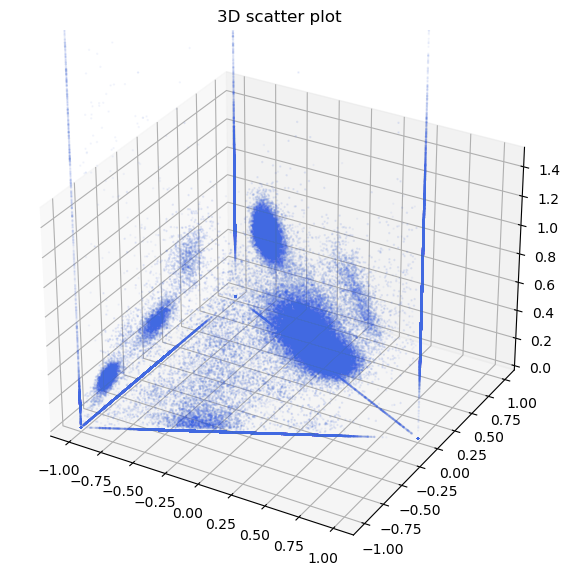

In [18]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(intensity_all['X_coor'], intensity_all['Y_coor'], intensity_all['G/A'], color = "royalblue",s=0.5,alpha=0.05)
ax.set_zlim3d(0,1.5)
plt.title("3D scatter plot")
plt.savefig(figure_dir/'colorcoding_3D.jpg')

In [19]:
rna_df[rna_df['Gene']=='Other']

,x_in_pix,y_in_pix,z_in_pix,Gene
20,1712,3395,87,Other
65,1334,1796,55,Other
91,2317,3972,85,Other
108,1044,1256,68,Other
113,901,1024,89,Other
...,...,...,...,...
169051,393,273,79,Other
169052,477,3419,11,Other
169053,2573,3828,18,Other
169054,3127,1722,79,Other
